# Experiments on data coming form NAB Benchmark

In [64]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from ad_toolkit.datasets import NabDataset, SupervisedDataset
from ad_toolkit.detectors import AutoEncoder, VariationalAutoEncoder, LSTM_AD, LSTM_ED
from ad_toolkit.evaluation import Result

In [65]:
from google.colab import drive
drive.mount('/content/drive')

root_dir = pathlib.Path("/content/drive/MyDrive/sops_anomaly_notebook")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [67]:
RESULTS_ROOT = root_dir / "results" / "nab_unsupervised" 

if not RESULTS_ROOT.exists():
    RESULTS_ROOT.mkdir(parents=True)

In [68]:
def max_metric(scores, targets, threshold_range, metric):
    best_metric = -1
    best_result = None
    best_threshold = 0
    for threshold in threshold_range:
        labels = (scores > threshold).astype(np.int32)
        result = Result(labels, targets)
        current_metric = getattr(result, metric, -1)
        if current_metric > best_metric:
            best_metric = current_metric
            best_result = result
            best_threshold = threshold
    return best_result, best_threshold, best_metric

def best_result(predictions, targets, max_error=None, upper_range=None, steps=200):
    """Try various threshold levels to get best scores."""
    
    if max_error is None:
        if upper_range is not None:
            upper = upper_range
        else:
            upper = min(3*np.mean(predictions), np.max(predictions))
        threshold_range = np.linspace(
            np.min(predictions), 
            upper,
#             np.max(predictions),
            steps,
        )
    else:
        threshold_range = np.linspace(0, max_error, 100)
        
    if np.any(targets):
        # If dataset contains anomalies maximize f1 score.
        result, threshold, _ = max_metric(predictions, targets, threshold_range, 'f1')
    else:
        # If dataset contains no anomalies maximize accuracy.
        result, threshold, _ = max_metric(predictions, targets, threshold_range, 'accuracy')
    return result, threshold

In [69]:
def save_results(index, results, anomalies, detector_name):
    root_folder = RESULTS_ROOT / detector_name
    scores_file = root_folder / "scores.csv"
    anomalies_file = root_folder / "anomalies"
    scores = [
        [r.accuracy, r.f1, r.precision, r.recall, r.roc_auc]
        for r
        in results
    ]
    columns = ['accuracy', 'f1_score', 'precision', 'recall', 'roc_auc']
    
    if not root_folder.exists():
        root_folder.mkdir(parents=True)
    
    pd.DataFrame(data=scores, index=index, columns=columns).to_csv(scores_file)
    
    if not anomalies_file.exists():
        anomalies_file.mkdir(parents=True)

    for fn, anomaly in zip(index, anomalies):
        pd.DataFrame(anomaly).to_csv(anomalies_file / fn.replace('/', '__'))

In [70]:
def test_for_all(model_factory, train_fn, detector_name, datasets, supervised=True):
    index = []
    all_results = []
    all_anomalies = []
    for dataset_name, files in datasets.items():
        if dataset_name == "artificialNoAnomaly":
            continue
        for filename in files:
            print(f"Testing on {dataset_name}/{filename} ...")
            dataset = NabDataset(dataset=dataset_name, file=filename)
            x, y = dataset.get_train_samples(standardize=True)
            if supervised:
                x_train = x[y != 1]
            else:
                x_train = x

            model = model_factory()
            train_fn(model, x_train)
            
            scores = model.predict(x)
            result, threshold = best_result(scores, y)
            # result, threshold = best_result(scores, y, upper_range=np.max(scores), steps=300)
            print(result)
            
            anomalies = (scores > threshold).astype(np.float32)
        
            index.append(f"{dataset_name}/{filename}")
            all_results.append(result)
            all_anomalies.append(anomalies)
            
    save_results(index, all_results, all_anomalies, detector_name)

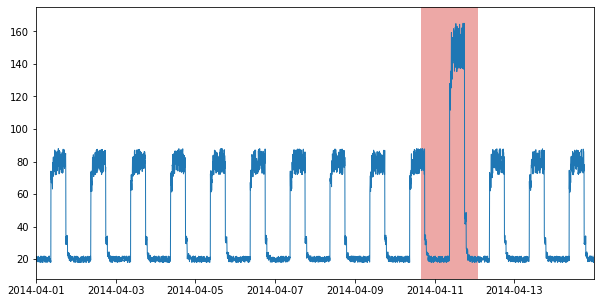

In [71]:
nab_simple = NabDataset()
nab_simple.plot()

## Autoencoder


### Fing best performing on the simple dataset

In [ ]:
x, y = nab_simple.get_train_samples(standardize=True)
x_train = x[y != 1]

model = AutoEncoder(window_size=100, layers=(64, 32, 16), latent_size=10, use_gpu=True)
model.train(x_train, epochs=40, learning_rate=1e-4)

scores = model.predict(x)
result, threshold = best_result(scores, y)
anomalies = (scores > threshold).astype(np.int32)

nab_simple.plot(anomalies={'autoenc': anomalies})
print(result)
plt.show()

### Test for all data

In [ ]:
test_for_all(
    lambda: AutoEncoder(window_size=100, layers=(64, 32, 16), latent_size=10, use_gpu=True),
    train_fn=lambda model, x: model.train(x, epochs=40, learning_rate=1e-4),
    detector_name="autoencoder",
    datasets=NabDataset.datasets(),
)

Testing on artificialNoAnomaly/art_daily_no_noise.csv ...
Result(accuracy=1.0,
	(tp, fp, tn, fn)=(0, 0, 4032, 0),
	precision=1.0,
	recall=1.0,
	f1=1.0,
	roc_auc=nan,
	y_pred%=0.0,
	y_label%=0.0,
)
Testing on artificialNoAnomaly/art_daily_perfect_square_wave.csv ...
Result(accuracy=1.0,
	(tp, fp, tn, fn)=(0, 0, 4032, 0),
	precision=1.0,
	recall=1.0,
	f1=1.0,
	roc_auc=nan,
	y_pred%=0.0,
	y_label%=0.0,
)
Testing on artificialNoAnomaly/art_daily_small_noise.csv ...
Result(accuracy=1.0,
	(tp, fp, tn, fn)=(0, 18, 4014, 0),
	precision=0.0,
	recall=1.0,
	f1=0.0,
	roc_auc=nan,
	y_pred%=0.004464285714285714,
	y_label%=0.0,
)
Testing on artificialNoAnomaly/art_flatline.csv ...
Result(accuracy=1.0,
	(tp, fp, tn, fn)=(0, 0, 4032, 0),
	precision=1.0,
	recall=1.0,
	f1=1.0,
	roc_auc=nan,
	y_pred%=0.0,
	y_label%=0.0,
)
Testing on artificialNoAnomaly/art_noisy.csv ...
Result(accuracy=1.0,
	(tp, fp, tn, fn)=(0, 19, 4013, 0),
	precision=0.0,
	recall=1.0,
	f1=0.0,
	roc_auc=nan,
	y_pred%=0.00471230158730158

## VariationalAutoEncoder

### Find best

Result(accuracy=0.94,
	(tp, fp, tn, fn)=(195, 15, 3614, 208),
	precision=0.93,
	recall=0.48,
	f1=0.64,
	roc_auc=0.74,
	y_pred%=0.052083333333333336,
	y_label%=0.09995039682539683,
)


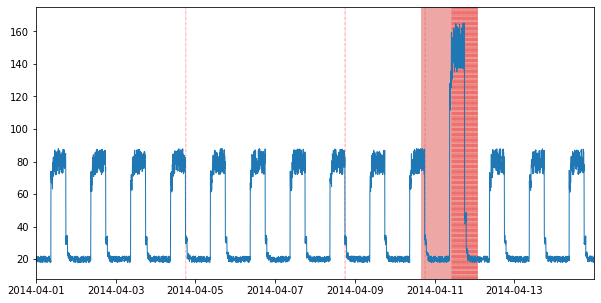

In [ ]:
x, y = nab_simple.get_train_samples(standardize=True)
x_train = x[y != 1]

model = VariationalAutoEncoder(window_size=100, layers=(64, 32,), latent_size=16, use_gpu=True)
model.train(x_train, epochs=40, learning_rate=1e-4)

scores = model.predict(x)
result, threshold = best_result(scores, y)
anomalies = (scores > threshold).astype(np.int32)

nab_simple.plot(anomalies={'vae': anomalies})
print(result)
plt.show()

### Run for all data

In [ ]:
test_for_all(
    lambda: VariationalAutoEncoder(window_size=100, layers=(64, 32,), latent_size=16, use_gpu=True),
    train_fn=lambda model, x: model.train(x, epochs=40, learning_rate=1e-4),
    detector_name="variationalautoencoder",
    datasets=NabDataset.datasets(),
)

Testing on artificialNoAnomaly/art_daily_no_noise.csv ...
Result(accuracy=1.0,
	(tp, fp, tn, fn)=(0, 20, 4012, 0),
	precision=0.0,
	recall=1.0,
	f1=0.0,
	roc_auc=nan,
	y_pred%=0.00496031746031746,
	y_label%=0.0,
)
Testing on artificialNoAnomaly/art_daily_perfect_square_wave.csv ...
Result(accuracy=1.0,
	(tp, fp, tn, fn)=(0, 7, 4025, 0),
	precision=0.0,
	recall=1.0,
	f1=0.0,
	roc_auc=nan,
	y_pred%=0.001736111111111111,
	y_label%=0.0,
)
Testing on artificialNoAnomaly/art_daily_small_noise.csv ...
Result(accuracy=1.0,
	(tp, fp, tn, fn)=(0, 18, 4014, 0),
	precision=0.0,
	recall=1.0,
	f1=0.0,
	roc_auc=nan,
	y_pred%=0.004464285714285714,
	y_label%=0.0,
)
Testing on artificialNoAnomaly/art_flatline.csv ...
Result(accuracy=1.0,
	(tp, fp, tn, fn)=(0, 0, 4032, 0),
	precision=1.0,
	recall=1.0,
	f1=1.0,
	roc_auc=nan,
	y_pred%=0.0,
	y_label%=0.0,
)
Testing on artificialNoAnomaly/art_noisy.csv ...
Result(accuracy=1.0,
	(tp, fp, tn, fn)=(0, 20, 4012, 0),
	precision=0.0,
	recall=1.0,
	f1=0.0,
	roc_auc

## LSTM_AD

### Find best

Epoch 0 loss: 0.7937982224624242
Epoch 1 loss: 0.7935859989351839
Epoch 2 loss: 0.7933739106896154
Epoch 3 loss: 0.7931619562800214
Epoch 4 loss: 0.7929501311056727
Epoch 5 loss: 0.7927384288625029
Epoch 6 loss: 0.7925268419829615
Epoch 7 loss: 0.7923153608198465
Epoch 8 loss: 0.7921039735362392
Epoch 9 loss: 0.7918926666003868
Epoch 10 loss: 0.791681425171134
Epoch 11 loss: 0.7914702331494474
Epoch 12 loss: 0.7912590730024728
Epoch 13 loss: 0.7910479255669176
Epoch 14 loss: 0.790836769971121
Epoch 15 loss: 0.7906255836988529
Epoch 16 loss: 0.7904143427542389
Epoch 17 loss: 0.7902030218785425
Epoch 18 loss: 0.789991594779414
Epoch 19 loss: 0.789780034342388
Epoch 20 loss: 0.7895683128042306
Epoch 21 loss: 0.789356401880385
Epoch 22 loss: 0.7891442728497489
Epoch 23 loss: 0.7889318966049211
Epoch 24 loss: 0.7887192436756764
Epoch 25 loss: 0.7885062842316051
Epoch 26 loss: 0.7882929880692185
Epoch 27 loss: 0.78807932458935
Epoch 28 loss: 0.7878652627711421
Epoch 29 loss: 0.78765077114847

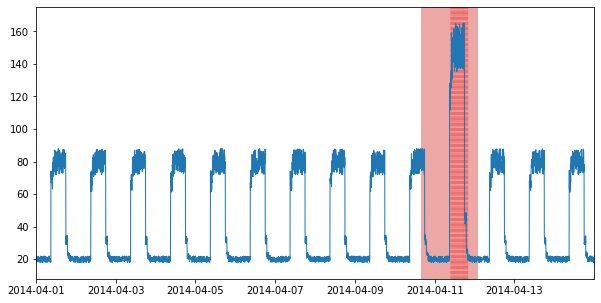

In [ ]:
x, y = nab_simple.get_train_samples(standardize=True)
x_train = x[y != 1]

model = LSTM_AD(window_size=20, hidden_size=16, use_gpu=True)
model.train(x_train, epochs=30, learning_rate=1e-4, verbose=True)

scores = model.predict(x)
result, threshold = best_result(scores, y, upper_range=np.max(scores), steps=300)
anomalies = (scores > threshold).astype(np.int32)

nab_simple.plot(anomalies={'lstm_ad': anomalies})
print(result)
plt.show()

### Run for all data

In [ ]:
def train_lstm_ad_model(model, x):
    if len(x) > 5000:
        model.train_with_slices(x, epochs=10, learning_rate=1e-4)
    else:
        model.train(x, epochs=30, learning_rate=1e-4)


test_for_all(
    lambda: LSTM_AD(window_size=20, hidden_size=16, use_gpu=True),
    train_fn=train_lstm_ad_model,
    detector_name="lstm_ad_norm_stand",
    datasets=NabDataset.datasets(),
)

Testing on artificialWithAnomaly/art_daily_flatmiddle.csv ...
Result(accuracy=0.64,
	(tp, fp, tn, fn)=(308, 1368, 2261, 95),
	precision=0.18,
	recall=0.76,
	f1=0.3,
	roc_auc=0.69,
	y_pred%=0.4156746031746032,
	y_label%=0.09995039682539683,
)
Testing on artificialWithAnomaly/art_daily_jumpsdown.csv ...
Result(accuracy=0.1,
	(tp, fp, tn, fn)=(402, 3629, 0, 1),
	precision=0.1,
	recall=1.0,
	f1=0.18,
	roc_auc=0.5,
	y_pred%=0.9997519841269841,
	y_label%=0.09995039682539683,
)
Testing on artificialWithAnomaly/art_daily_jumpsup.csv ...
Result(accuracy=0.93,
	(tp, fp, tn, fn)=(128, 1, 3628, 275),
	precision=0.99,
	recall=0.32,
	f1=0.48,
	roc_auc=0.66,
	y_pred%=0.031994047619047616,
	y_label%=0.09995039682539683,
)
Testing on artificialWithAnomaly/art_daily_nojump.csv ...
Result(accuracy=0.1,
	(tp, fp, tn, fn)=(403, 3628, 1, 0),
	precision=0.1,
	recall=1.0,
	f1=0.18,
	roc_auc=0.5,
	y_pred%=0.9997519841269841,
	y_label%=0.09995039682539683,
)
Testing on artificialWithAnomaly/art_increase_spike_d

## LSTM_ED

### Find best

Result(accuracy=0.93,
	(tp, fp, tn, fn)=(122, 3, 3626, 281),
	precision=0.98,
	recall=0.3,
	f1=0.46,
	roc_auc=0.65,
	y_pred%=0.031001984126984128,
	y_label%=0.09995039682539683,
)


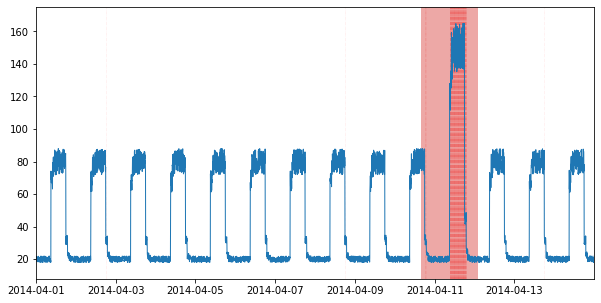

In [ ]:
x, y = nab_simple.get_train_samples(standardize=True)
x_train = x[y != 1]


model = LSTM_ED(sequence_len=30, stride=1, hidden_size=16, use_gpu=True)
model.train(x_train, epochs=40, learning_rate=1e-4)

scores = model.predict(x)
result, threshold = best_result(scores, y, upper_range=np.max(scores), steps=300)
anomalies = (scores > threshold).astype(np.int32)

nab_simple.plot(anomalies={'lstm_ed': anomalies})
print(result)
plt.show()

## Run for all data

In [ ]:
test_for_all(
    lambda: LSTM_ED(sequence_len=30, stride=1, hidden_size=16, use_gpu=True),
    train_fn=lambda model, x: model.train(x, epochs=40, learning_rate=1e-4),
    detector_name="lstm_ed",
    datasets=NabDataset.datasets(),
)

Testing on artificialWithAnomaly/art_daily_flatmiddle.csv ...
Result(accuracy=0.74,
	(tp, fp, tn, fn)=(269, 931, 2698, 134),
	precision=0.22,
	recall=0.67,
	f1=0.34,
	roc_auc=0.71,
	y_pred%=0.2976190476190476,
	y_label%=0.09995039682539683,
)
Testing on artificialWithAnomaly/art_daily_jumpsdown.csv ...
Result(accuracy=0.92,
	(tp, fp, tn, fn)=(104, 6, 3623, 299),
	precision=0.95,
	recall=0.26,
	f1=0.41,
	roc_auc=0.63,
	y_pred%=0.027281746031746032,
	y_label%=0.09995039682539683,
)
Testing on artificialWithAnomaly/art_daily_jumpsup.csv ...
Result(accuracy=0.93,
	(tp, fp, tn, fn)=(121, 10, 3619, 282),
	precision=0.92,
	recall=0.3,
	f1=0.45,
	roc_auc=0.65,
	y_pred%=0.03249007936507937,
	y_label%=0.09995039682539683,
)
Testing on artificialWithAnomaly/art_daily_nojump.csv ...
Result(accuracy=0.12,
	(tp, fp, tn, fn)=(403, 3548, 81, 0),
	precision=0.1,
	recall=1.0,
	f1=0.19,
	roc_auc=0.51,
	y_pred%=0.9799107142857143,
	y_label%=0.09995039682539683,
)
Testing on artificialWithAnomaly/art_incre

## Donut

In [ ]:
! pip install "ad_toolkit[donut] @ git+https://github.com/pbudzyns/ad_toolkit.git"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/pbudzyns/ad_toolkit.git to /tmp/pip-install-csnruhbl/ad-toolkit_7536b518e061418e853040d42d88a132
  Running command git clone -q https://github.com/pbudzyns/ad_toolkit.git /tmp/pip-install-csnruhbl/ad-toolkit_7536b518e061418e853040d42d88a132
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Cloning https://github.com/korepwx/donut.git to /tmp/pip-install-csnruhbl/donut_542759d8518947c2924f37fec4492d77
  Running command git clone -q https://github.com/korepwx/donut.git /tmp/pip-install-csnruhbl/donut_542759d8518947c2924f37fec4492d77
  Cloning https://github.com/haowen-xu/tfsnippet.git (to revision v0.1.2) to /tmp/pip-install-csnruhbl/tfsnippet_7f8a5dabeb7f4984b9ac865c71d403ad
  Running command git clone -q https://github.com/haowen-xu/tfsnippet.git /tmp/pip-install-csnruhbl/tfsnippet_7

In [ ]:
from ad_toolkit.detectors import Donut

### Find best

Trainable Parameters                   (11,896 in total)
--------------------------------------------------------
donut/p_x_given_z/x_mean/bias           (100,)       100
donut/p_x_given_z/x_mean/kernel         (16, 100)  1,600
donut/p_x_given_z/x_std/bias            (100,)       100
donut/p_x_given_z/x_std/kernel          (16, 100)  1,600
donut/q_z_given_x/z_mean/bias           (8,)           8
donut/q_z_given_x/z_mean/kernel         (64, 8)      512
donut/q_z_given_x/z_std/bias            (8,)           8
donut/q_z_given_x/z_std/kernel          (64, 8)      512
sequential/forward/_0/dense/bias        (64,)         64
sequential/forward/_0/dense/kernel      (8, 64)      512
sequential/forward/_1/dense_1/bias      (32,)         32
sequential/forward/_1/dense_1/kernel    (64, 32)   2,048
sequential/forward/_2/dense_2/bias      (16,)         16
sequential/forward/_2/dense_2/kernel    (32, 16)     512
sequential_1/forward/_0/dense_3/bias    (16,)         16
sequential_1/forward/_0/dense_3

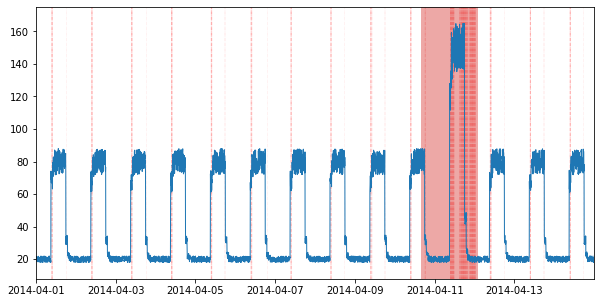

In [ ]:
x, y = nab_simple.data

with tf.Graph().as_default():
    model = Donut(window_size=100, latent_size=8, layers=(64,32,16))
    model.train(x, labels=y, epochs=350)

    scores = model.predict(x)
result, threshold = best_result(scores, y, upper_range=np.max(scores)+0.1, steps=400)
anomalies = (scores > threshold).astype(np.int32)

nab_simple.plot(anomalies={'vae': anomalies})
print(result)
plt.show()

### Run for all

In [ ]:
import datetime

def fake_index(data):
    start = data.index[0]
    new_idx = [start]
    for i in range(1, len(data)):
        new_idx.append(start + datetime.timedelta(minutes=(i*5)))
    return new_idx

In [ ]:
datasets = NabDataset.datasets()
index = []
all_results = []
all_anomalies = []
for dataset_name, files in datasets.items():
    if dataset_name == "artificialNoAnomaly":
        continue
    for filename in files:
        print(f"Testing on {dataset_name}/{filename} ...")
        dataset = NabDataset(dataset=dataset_name, file=filename)
        x, y = dataset.data

        if np.any(x.index.duplicated()):
            print("reindexing")
            new_idx = fake_index(x)
            x.index = new_idx
            y.index = new_idx

        with tf.Graph().as_default(), tf.device('/gpu:0'):
            model = Donut(window_size=100, latent_size=8, layers=(64,32,16))
            model.train(x, labels=y, epochs=350)
            
            scores = model.predict(x)
        
        result, threshold = best_result(scores, y, upper_range=np.max(scores)+0.1, steps=400)
        print(result)
        
        anomalies = (scores > threshold).astype(np.float32)
    
        index.append(f"{dataset_name}/{filename}")
        all_results.append(result)
        all_anomalies.append(anomalies)
        
save_results(index, all_results, all_anomalies, "donut")

Testing on artificialWithAnomaly/art_daily_flatmiddle.csv ...
Trainable Parameters                   (11,896 in total)
--------------------------------------------------------
donut/p_x_given_z/x_mean/bias           (100,)       100
donut/p_x_given_z/x_mean/kernel         (16, 100)  1,600
donut/p_x_given_z/x_std/bias            (100,)       100
donut/p_x_given_z/x_std/kernel          (16, 100)  1,600
donut/q_z_given_x/z_mean/bias           (8,)           8
donut/q_z_given_x/z_mean/kernel         (64, 8)      512
donut/q_z_given_x/z_std/bias            (8,)           8
donut/q_z_given_x/z_std/kernel          (64, 8)      512
sequential/forward/_0/dense/bias        (64,)         64
sequential/forward/_0/dense/kernel      (8, 64)      512
sequential/forward/_1/dense_1/bias      (32,)         32
sequential/forward/_1/dense_1/kernel    (64, 32)   2,048
sequential/forward/_2/dense_2/bias      (16,)         16
sequential/forward/_2/dense_2/kernel    (32, 16)     512
sequential_1/forward/_0/de

INFO:tensorflow:Restoring parameters from /tmp/tmp7o9luqhg/variables.dat-2900


Result(accuracy=0.67,
	(tp, fp, tn, fn)=(290, 1206, 2423, 113),
	precision=0.19,
	recall=0.72,
	f1=0.31,
	roc_auc=0.69,
	y_pred%=0.37103174603174605,
	y_label%=0.09995039682539683,
)
Testing on artificialWithAnomaly/art_daily_jumpsdown.csv ...
Trainable Parameters                   (11,896 in total)
--------------------------------------------------------
donut/p_x_given_z/x_mean/bias           (100,)       100
donut/p_x_given_z/x_mean/kernel         (16, 100)  1,600
donut/p_x_given_z/x_std/bias            (100,)       100
donut/p_x_given_z/x_std/kernel          (16, 100)  1,600
donut/q_z_given_x/z_mean/bias           (8,)           8
donut/q_z_given_x/z_mean/kernel         (64, 8)      512
donut/q_z_given_x/z_std/bias            (8,)           8
donut/q_z_given_x/z_std/kernel          (64, 8)      512
sequential/forward/_0/dense/bias        (64,)         64
sequential/forward/_0/dense/kernel      (8, 64)      512
sequential/forward/_1/dense_1/bias      (32,)         32
sequential/forw

INFO:tensorflow:Restoring parameters from /tmp/tmpou8hjbcl/variables.dat-1400


Result(accuracy=0.45,
	(tp, fp, tn, fn)=(291, 2122, 1507, 112),
	precision=0.12,
	recall=0.72,
	f1=0.21,
	roc_auc=0.57,
	y_pred%=0.5984623015873016,
	y_label%=0.09995039682539683,
)
Testing on artificialWithAnomaly/art_daily_jumpsup.csv ...
Trainable Parameters                   (11,896 in total)
--------------------------------------------------------
donut/p_x_given_z/x_mean/bias           (100,)       100
donut/p_x_given_z/x_mean/kernel         (16, 100)  1,600
donut/p_x_given_z/x_std/bias            (100,)       100
donut/p_x_given_z/x_std/kernel          (16, 100)  1,600
donut/q_z_given_x/z_mean/bias           (8,)           8
donut/q_z_given_x/z_mean/kernel         (64, 8)      512
donut/q_z_given_x/z_std/bias            (8,)           8
donut/q_z_given_x/z_std/kernel          (64, 8)      512
sequential/forward/_0/dense/bias        (64,)         64
sequential/forward/_0/dense/kernel      (8, 64)      512
sequential/forward/_1/dense_1/bias      (32,)         32
sequential/forward

INFO:tensorflow:Restoring parameters from /tmp/tmp6pdzyh_r/variables.dat-100


Result(accuracy=0.81,
	(tp, fp, tn, fn)=(139, 507, 3122, 264),
	precision=0.22,
	recall=0.34,
	f1=0.27,
	roc_auc=0.6,
	y_pred%=0.16021825396825398,
	y_label%=0.09995039682539683,
)
Testing on artificialWithAnomaly/art_daily_nojump.csv ...
Trainable Parameters                   (11,896 in total)
--------------------------------------------------------
donut/p_x_given_z/x_mean/bias           (100,)       100
donut/p_x_given_z/x_mean/kernel         (16, 100)  1,600
donut/p_x_given_z/x_std/bias            (100,)       100
donut/p_x_given_z/x_std/kernel          (16, 100)  1,600
donut/q_z_given_x/z_mean/bias           (8,)           8
donut/q_z_given_x/z_mean/kernel         (64, 8)      512
donut/q_z_given_x/z_std/bias            (8,)           8
donut/q_z_given_x/z_std/kernel          (64, 8)      512
sequential/forward/_0/dense/bias        (64,)         64
sequential/forward/_0/dense/kernel      (8, 64)      512
sequential/forward/_1/dense_1/bias      (32,)         32
sequential/forward/_

INFO:tensorflow:Restoring parameters from /tmp/tmptkrczomo/variables.dat-2700


Result(accuracy=0.43,
	(tp, fp, tn, fn)=(323, 2238, 1391, 80),
	precision=0.13,
	recall=0.8,
	f1=0.22,
	roc_auc=0.59,
	y_pred%=0.6351686507936508,
	y_label%=0.09995039682539683,
)
Testing on artificialWithAnomaly/art_increase_spike_density.csv ...
Trainable Parameters                   (11,896 in total)
--------------------------------------------------------
donut/p_x_given_z/x_mean/bias           (100,)       100
donut/p_x_given_z/x_mean/kernel         (16, 100)  1,600
donut/p_x_given_z/x_std/bias            (100,)       100
donut/p_x_given_z/x_std/kernel          (16, 100)  1,600
donut/q_z_given_x/z_mean/bias           (8,)           8
donut/q_z_given_x/z_mean/kernel         (64, 8)      512
donut/q_z_given_x/z_std/bias            (8,)           8
donut/q_z_given_x/z_std/kernel          (64, 8)      512
sequential/forward/_0/dense/bias        (64,)         64
sequential/forward/_0/dense/kernel      (8, 64)      512
sequential/forward/_1/dense_1/bias      (32,)         32
sequential/

INFO:tensorflow:Restoring parameters from /tmp/tmpigbzfgr0/variables.dat-3700


Result(accuracy=0.53,
	(tp, fp, tn, fn)=(248, 1754, 1875, 155),
	precision=0.12,
	recall=0.62,
	f1=0.21,
	roc_auc=0.57,
	y_pred%=0.4965277777777778,
	y_label%=0.09995039682539683,
)
Testing on artificialWithAnomaly/art_load_balancer_spikes.csv ...
Trainable Parameters                   (11,896 in total)
--------------------------------------------------------
donut/p_x_given_z/x_mean/bias           (100,)       100
donut/p_x_given_z/x_mean/kernel         (16, 100)  1,600
donut/p_x_given_z/x_std/bias            (100,)       100
donut/p_x_given_z/x_std/kernel          (16, 100)  1,600
donut/q_z_given_x/z_mean/bias           (8,)           8
donut/q_z_given_x/z_mean/kernel         (64, 8)      512
donut/q_z_given_x/z_std/bias            (8,)           8
donut/q_z_given_x/z_std/kernel          (64, 8)      512
sequential/forward/_0/dense/bias        (64,)         64
sequential/forward/_0/dense/kernel      (8, 64)      512
sequential/forward/_1/dense_1/bias      (32,)         32
sequential/

INFO:tensorflow:Restoring parameters from /tmp/tmpphipe5rk/variables.dat-200


Result(accuracy=0.89,
	(tp, fp, tn, fn)=(193, 231, 3398, 210),
	precision=0.46,
	recall=0.48,
	f1=0.47,
	roc_auc=0.71,
	y_pred%=0.10515873015873016,
	y_label%=0.09995039682539683,
)
Testing on realAWSCloudwatch/ec2_cpu_utilization_24ae8d.csv ...
Trainable Parameters                   (11,896 in total)
--------------------------------------------------------
donut/p_x_given_z/x_mean/bias           (100,)       100
donut/p_x_given_z/x_mean/kernel         (16, 100)  1,600
donut/p_x_given_z/x_std/bias            (100,)       100
donut/p_x_given_z/x_std/kernel          (16, 100)  1,600
donut/q_z_given_x/z_mean/bias           (8,)           8
donut/q_z_given_x/z_mean/kernel         (64, 8)      512
donut/q_z_given_x/z_std/bias            (8,)           8
donut/q_z_given_x/z_std/kernel          (64, 8)      512
sequential/forward/_0/dense/bias        (64,)         64
sequential/forward/_0/dense/kernel      (8, 64)      512
sequential/forward/_1/dense_1/bias      (32,)         32
sequential/fo

INFO:tensorflow:Restoring parameters from /tmp/tmp5vyuu1ig/variables.dat-500


Result(accuracy=0.88,
	(tp, fp, tn, fn)=(73, 146, 3484, 329),
	precision=0.33,
	recall=0.18,
	f1=0.24,
	roc_auc=0.57,
	y_pred%=0.05431547619047619,
	y_label%=0.09970238095238096,
)
Testing on realAWSCloudwatch/ec2_cpu_utilization_53ea38.csv ...
Trainable Parameters                   (11,896 in total)
--------------------------------------------------------
donut/p_x_given_z/x_mean/bias           (100,)       100
donut/p_x_given_z/x_mean/kernel         (16, 100)  1,600
donut/p_x_given_z/x_std/bias            (100,)       100
donut/p_x_given_z/x_std/kernel          (16, 100)  1,600
donut/q_z_given_x/z_mean/bias           (8,)           8
donut/q_z_given_x/z_mean/kernel         (64, 8)      512
donut/q_z_given_x/z_std/bias            (8,)           8
donut/q_z_given_x/z_std/kernel          (64, 8)      512
sequential/forward/_0/dense/bias        (64,)         64
sequential/forward/_0/dense/kernel      (8, 64)      512
sequential/forward/_1/dense_1/bias      (32,)         32
sequential/for

INFO:tensorflow:Restoring parameters from /tmp/tmpq0sh1r8e/variables.dat-3100


Result(accuracy=0.48,
	(tp, fp, tn, fn)=(254, 1945, 1685, 148),
	precision=0.12,
	recall=0.63,
	f1=0.2,
	roc_auc=0.55,
	y_pred%=0.5453869047619048,
	y_label%=0.09970238095238096,
)
Testing on realAWSCloudwatch/ec2_cpu_utilization_5f5533.csv ...
Trainable Parameters                   (11,896 in total)
--------------------------------------------------------
donut/p_x_given_z/x_mean/bias           (100,)       100
donut/p_x_given_z/x_mean/kernel         (16, 100)  1,600
donut/p_x_given_z/x_std/bias            (100,)       100
donut/p_x_given_z/x_std/kernel          (16, 100)  1,600
donut/q_z_given_x/z_mean/bias           (8,)           8
donut/q_z_given_x/z_mean/kernel         (64, 8)      512
donut/q_z_given_x/z_std/bias            (8,)           8
donut/q_z_given_x/z_std/kernel          (64, 8)      512
sequential/forward/_0/dense/bias        (64,)         64
sequential/forward/_0/dense/kernel      (8, 64)      512
sequential/forward/_1/dense_1/bias      (32,)         32
sequential/for

INFO:tensorflow:Restoring parameters from /tmp/tmp74yyvkqj/variables.dat-100


Result(accuracy=0.12,
	(tp, fp, tn, fn)=(402, 3531, 99, 0),
	precision=0.1,
	recall=1.0,
	f1=0.19,
	roc_auc=0.51,
	y_pred%=0.9754464285714286,
	y_label%=0.09970238095238096,
)
Testing on realAWSCloudwatch/ec2_cpu_utilization_77c1ca.csv ...
Trainable Parameters                   (11,896 in total)
--------------------------------------------------------
donut/p_x_given_z/x_mean/bias           (100,)       100
donut/p_x_given_z/x_mean/kernel         (16, 100)  1,600
donut/p_x_given_z/x_std/bias            (100,)       100
donut/p_x_given_z/x_std/kernel          (16, 100)  1,600
donut/q_z_given_x/z_mean/bias           (8,)           8
donut/q_z_given_x/z_mean/kernel         (64, 8)      512
donut/q_z_given_x/z_std/bias            (8,)           8
donut/q_z_given_x/z_std/kernel          (64, 8)      512
sequential/forward/_0/dense/bias        (64,)         64
sequential/forward/_0/dense/kernel      (8, 64)      512
sequential/forward/_1/dense_1/bias      (32,)         32
sequential/forward/

INFO:tensorflow:Restoring parameters from /tmp/tmprd00j597/variables.dat-200


Result(accuracy=0.76,
	(tp, fp, tn, fn)=(186, 758, 2871, 217),
	precision=0.2,
	recall=0.46,
	f1=0.28,
	roc_auc=0.63,
	y_pred%=0.23412698412698413,
	y_label%=0.09995039682539683,
)
Testing on realAWSCloudwatch/ec2_cpu_utilization_825cc2.csv ...
Trainable Parameters                   (11,896 in total)
--------------------------------------------------------
donut/p_x_given_z/x_mean/bias           (100,)       100
donut/p_x_given_z/x_mean/kernel         (16, 100)  1,600
donut/p_x_given_z/x_std/bias            (100,)       100
donut/p_x_given_z/x_std/kernel          (16, 100)  1,600
donut/q_z_given_x/z_mean/bias           (8,)           8
donut/q_z_given_x/z_mean/kernel         (64, 8)      512
donut/q_z_given_x/z_std/bias            (8,)           8
donut/q_z_given_x/z_std/kernel          (64, 8)      512
sequential/forward/_0/dense/bias        (64,)         64
sequential/forward/_0/dense/kernel      (8, 64)      512
sequential/forward/_1/dense_1/bias      (32,)         32
sequential/for

INFO:tensorflow:Restoring parameters from /tmp/tmp28fqyjqi/variables.dat-3700


Result(accuracy=0.93,
	(tp, fp, tn, fn)=(113, 61, 3628, 230),
	precision=0.65,
	recall=0.33,
	f1=0.44,
	roc_auc=0.66,
	y_pred%=0.043154761904761904,
	y_label%=0.08506944444444445,
)
Testing on realAWSCloudwatch/ec2_cpu_utilization_ac20cd.csv ...
Trainable Parameters                   (11,896 in total)
--------------------------------------------------------
donut/p_x_given_z/x_mean/bias           (100,)       100
donut/p_x_given_z/x_mean/kernel         (16, 100)  1,600
donut/p_x_given_z/x_std/bias            (100,)       100
donut/p_x_given_z/x_std/kernel          (16, 100)  1,600
donut/q_z_given_x/z_mean/bias           (8,)           8
donut/q_z_given_x/z_mean/kernel         (64, 8)      512
donut/q_z_given_x/z_std/bias            (8,)           8
donut/q_z_given_x/z_std/kernel          (64, 8)      512
sequential/forward/_0/dense/bias        (64,)         64
sequential/forward/_0/dense/kernel      (8, 64)      512
sequential/forward/_1/dense_1/bias      (32,)         32
sequential/fo

INFO:tensorflow:Restoring parameters from /tmp/tmpfkjr58aw/variables.dat-100


Result(accuracy=0.87,
	(tp, fp, tn, fn)=(204, 308, 3321, 199),
	precision=0.4,
	recall=0.51,
	f1=0.45,
	roc_auc=0.71,
	y_pred%=0.12698412698412698,
	y_label%=0.09995039682539683,
)
Testing on realAWSCloudwatch/ec2_cpu_utilization_c6585a.csv ...
Trainable Parameters                   (11,896 in total)
--------------------------------------------------------
donut/p_x_given_z/x_mean/bias           (100,)       100
donut/p_x_given_z/x_mean/kernel         (16, 100)  1,600
donut/p_x_given_z/x_std/bias            (100,)       100
donut/p_x_given_z/x_std/kernel          (16, 100)  1,600
donut/q_z_given_x/z_mean/bias           (8,)           8
donut/q_z_given_x/z_mean/kernel         (64, 8)      512
donut/q_z_given_x/z_std/bias            (8,)           8
donut/q_z_given_x/z_std/kernel          (64, 8)      512
sequential/forward/_0/dense/bias        (64,)         64
sequential/forward/_0/dense/kernel      (8, 64)      512
sequential/forward/_1/dense_1/bias      (32,)         32
sequential/for

INFO:tensorflow:Restoring parameters from /tmp/tmp5uw8nl8x/variables.dat-3200


Result(accuracy=1.0,
	(tp, fp, tn, fn)=(0, 18, 4014, 0),
	precision=0.0,
	recall=1.0,
	f1=0.0,
	roc_auc=nan,
	y_pred%=0.004464285714285714,
	y_label%=0.0,
)
Testing on realAWSCloudwatch/ec2_cpu_utilization_fe7f93.csv ...
Trainable Parameters                   (11,896 in total)
--------------------------------------------------------
donut/p_x_given_z/x_mean/bias           (100,)       100
donut/p_x_given_z/x_mean/kernel         (16, 100)  1,600
donut/p_x_given_z/x_std/bias            (100,)       100
donut/p_x_given_z/x_std/kernel          (16, 100)  1,600
donut/q_z_given_x/z_mean/bias           (8,)           8
donut/q_z_given_x/z_mean/kernel         (64, 8)      512
donut/q_z_given_x/z_std/bias            (8,)           8
donut/q_z_given_x/z_std/kernel          (64, 8)      512
sequential/forward/_0/dense/bias        (64,)         64
sequential/forward/_0/dense/kernel      (8, 64)      512
sequential/forward/_1/dense_1/bias      (32,)         32
sequential/forward/_1/dense_1/kernel  

INFO:tensorflow:Restoring parameters from /tmp/tmppy4en6sn/variables.dat-1900


Result(accuracy=0.86,
	(tp, fp, tn, fn)=(117, 286, 3341, 288),
	precision=0.29,
	recall=0.29,
	f1=0.29,
	roc_auc=0.61,
	y_pred%=0.09995039682539683,
	y_label%=0.10044642857142858,
)
Testing on realAWSCloudwatch/ec2_disk_write_bytes_1ef3de.csv ...
reindexing
Trainable Parameters                   (11,896 in total)
--------------------------------------------------------
donut/p_x_given_z/x_mean/bias           (100,)       100
donut/p_x_given_z/x_mean/kernel         (16, 100)  1,600
donut/p_x_given_z/x_std/bias            (100,)       100
donut/p_x_given_z/x_std/kernel          (16, 100)  1,600
donut/q_z_given_x/z_mean/bias           (8,)           8
donut/q_z_given_x/z_mean/kernel         (64, 8)      512
donut/q_z_given_x/z_std/bias            (8,)           8
donut/q_z_given_x/z_std/kernel          (64, 8)      512
sequential/forward/_0/dense/bias        (64,)         64
sequential/forward/_0/dense/kernel      (8, 64)      512
sequential/forward/_1/dense_1/bias      (32,)         32
s

INFO:tensorflow:Restoring parameters from /tmp/tmpgamhcl6s/variables.dat-2200


Result(accuracy=0.37,
	(tp, fp, tn, fn)=(385, 2906, 1351, 88),
	precision=0.12,
	recall=0.81,
	f1=0.2,
	roc_auc=0.57,
	y_pred%=0.6957716701902749,
	y_label%=0.1,
)
Testing on realAWSCloudwatch/ec2_disk_write_bytes_c0d644.csv ...
Trainable Parameters                   (11,896 in total)
--------------------------------------------------------
donut/p_x_given_z/x_mean/bias           (100,)       100
donut/p_x_given_z/x_mean/kernel         (16, 100)  1,600
donut/p_x_given_z/x_std/bias            (100,)       100
donut/p_x_given_z/x_std/kernel          (16, 100)  1,600
donut/q_z_given_x/z_mean/bias           (8,)           8
donut/q_z_given_x/z_mean/kernel         (64, 8)      512
donut/q_z_given_x/z_std/bias            (8,)           8
donut/q_z_given_x/z_std/kernel          (64, 8)      512
sequential/forward/_0/dense/bias        (64,)         64
sequential/forward/_0/dense/kernel      (8, 64)      512
sequential/forward/_1/dense_1/bias      (32,)         32
sequential/forward/_1/dense_1/

INFO:tensorflow:Restoring parameters from /tmp/tmpayep1us5/variables.dat-400


Result(accuracy=0.77,
	(tp, fp, tn, fn)=(155, 675, 2952, 250),
	precision=0.19,
	recall=0.38,
	f1=0.25,
	roc_auc=0.6,
	y_pred%=0.2058531746031746,
	y_label%=0.10044642857142858,
)
Testing on realAWSCloudwatch/ec2_network_in_257a54.csv ...
Trainable Parameters                   (11,896 in total)
--------------------------------------------------------
donut/p_x_given_z/x_mean/bias           (100,)       100
donut/p_x_given_z/x_mean/kernel         (16, 100)  1,600
donut/p_x_given_z/x_std/bias            (100,)       100
donut/p_x_given_z/x_std/kernel          (16, 100)  1,600
donut/q_z_given_x/z_mean/bias           (8,)           8
donut/q_z_given_x/z_mean/kernel         (64, 8)      512
donut/q_z_given_x/z_std/bias            (8,)           8
donut/q_z_given_x/z_std/kernel          (64, 8)      512
sequential/forward/_0/dense/bias        (64,)         64
sequential/forward/_0/dense/kernel      (8, 64)      512
sequential/forward/_1/dense_1/bias      (32,)         32
sequential/forward/_

INFO:tensorflow:Restoring parameters from /tmp/tmpkdsalh_g/variables.dat-1000


Result(accuracy=0.91,
	(tp, fp, tn, fn)=(98, 49, 3580, 305),
	precision=0.67,
	recall=0.24,
	f1=0.36,
	roc_auc=0.61,
	y_pred%=0.036458333333333336,
	y_label%=0.09995039682539683,
)
Testing on realAWSCloudwatch/ec2_network_in_5abac7.csv ...
reindexing
Trainable Parameters                   (11,896 in total)
--------------------------------------------------------
donut/p_x_given_z/x_mean/bias           (100,)       100
donut/p_x_given_z/x_mean/kernel         (16, 100)  1,600
donut/p_x_given_z/x_std/bias            (100,)       100
donut/p_x_given_z/x_std/kernel          (16, 100)  1,600
donut/q_z_given_x/z_mean/bias           (8,)           8
donut/q_z_given_x/z_mean/kernel         (64, 8)      512
donut/q_z_given_x/z_std/bias            (8,)           8
donut/q_z_given_x/z_std/kernel          (64, 8)      512
sequential/forward/_0/dense/bias        (64,)         64
sequential/forward/_0/dense/kernel      (8, 64)      512
sequential/forward/_1/dense_1/bias      (32,)         32
sequenti

INFO:tensorflow:Restoring parameters from /tmp/tmpb12h996u/variables.dat-4300


Result(accuracy=0.64,
	(tp, fp, tn, fn)=(311, 1546, 2710, 163),
	precision=0.17,
	recall=0.66,
	f1=0.27,
	roc_auc=0.65,
	y_pred%=0.39260042283298097,
	y_label%=0.10021141649048626,
)
Testing on realAWSCloudwatch/elb_request_count_8c0756.csv ...
Trainable Parameters                   (11,896 in total)
--------------------------------------------------------
donut/p_x_given_z/x_mean/bias           (100,)       100
donut/p_x_given_z/x_mean/kernel         (16, 100)  1,600
donut/p_x_given_z/x_std/bias            (100,)       100
donut/p_x_given_z/x_std/kernel          (16, 100)  1,600
donut/q_z_given_x/z_mean/bias           (8,)           8
donut/q_z_given_x/z_mean/kernel         (64, 8)      512
donut/q_z_given_x/z_std/bias            (8,)           8
donut/q_z_given_x/z_std/kernel          (64, 8)      512
sequential/forward/_0/dense/bias        (64,)         64
sequential/forward/_0/dense/kernel      (8, 64)      512
sequential/forward/_1/dense_1/bias      (32,)         32
sequential/for

INFO:tensorflow:Restoring parameters from /tmp/tmphjr225bk/variables.dat-2200


Result(accuracy=0.51,
	(tp, fp, tn, fn)=(255, 1828, 1802, 147),
	precision=0.12,
	recall=0.63,
	f1=0.21,
	roc_auc=0.57,
	y_pred%=0.5166170634920635,
	y_label%=0.09970238095238096,
)
Testing on realAWSCloudwatch/grok_asg_anomaly.csv ...
Trainable Parameters                   (11,896 in total)
--------------------------------------------------------
donut/p_x_given_z/x_mean/bias           (100,)       100
donut/p_x_given_z/x_mean/kernel         (16, 100)  1,600
donut/p_x_given_z/x_std/bias            (100,)       100
donut/p_x_given_z/x_std/kernel          (16, 100)  1,600
donut/q_z_given_x/z_mean/bias           (8,)           8
donut/q_z_given_x/z_mean/kernel         (64, 8)      512
donut/q_z_given_x/z_std/bias            (8,)           8
donut/q_z_given_x/z_std/kernel          (64, 8)      512
sequential/forward/_0/dense/bias        (64,)         64
sequential/forward/_0/dense/kernel      (8, 64)      512
sequential/forward/_1/dense_1/bias      (32,)         32
sequential/forward/_1/d

INFO:tensorflow:Restoring parameters from /tmp/tmpkzfa9ofg/variables.dat-100


Result(accuracy=0.14,
	(tp, fp, tn, fn)=(449, 3935, 221, 16),
	precision=0.1,
	recall=0.97,
	f1=0.19,
	roc_auc=0.51,
	y_pred%=0.9487123999134387,
	y_label%=0.10062756979008873,
)
Testing on realAWSCloudwatch/iio_us-east-1_i-a2eb1cd9_NetworkIn.csv ...
Trainable Parameters                   (11,896 in total)
--------------------------------------------------------
donut/p_x_given_z/x_mean/bias           (100,)       100
donut/p_x_given_z/x_mean/kernel         (16, 100)  1,600
donut/p_x_given_z/x_std/bias            (100,)       100
donut/p_x_given_z/x_std/kernel          (16, 100)  1,600
donut/q_z_given_x/z_mean/bias           (8,)           8
donut/q_z_given_x/z_mean/kernel         (64, 8)      512
donut/q_z_given_x/z_std/bias            (8,)           8
donut/q_z_given_x/z_std/kernel          (64, 8)      512
sequential/forward/_0/dense/bias        (64,)         64
sequential/forward/_0/dense/kernel      (8, 64)      512
sequential/forward/_1/dense_1/bias      (32,)         32
sequenti

INFO:tensorflow:Restoring parameters from /tmp/tmptc63a0n3/variables.dat-700


Result(accuracy=0.81,
	(tp, fp, tn, fn)=(78, 189, 928, 48),
	precision=0.29,
	recall=0.62,
	f1=0.4,
	roc_auc=0.72,
	y_pred%=0.21480289621882542,
	y_label%=0.10136765888978279,
)
Testing on realAWSCloudwatch/rds_cpu_utilization_cc0c53.csv ...
Trainable Parameters                   (11,896 in total)
--------------------------------------------------------
donut/p_x_given_z/x_mean/bias           (100,)       100
donut/p_x_given_z/x_mean/kernel         (16, 100)  1,600
donut/p_x_given_z/x_std/bias            (100,)       100
donut/p_x_given_z/x_std/kernel          (16, 100)  1,600
donut/q_z_given_x/z_mean/bias           (8,)           8
donut/q_z_given_x/z_mean/kernel         (64, 8)      512
donut/q_z_given_x/z_std/bias            (8,)           8
donut/q_z_given_x/z_std/kernel          (64, 8)      512
sequential/forward/_0/dense/bias        (64,)         64
sequential/forward/_0/dense/kernel      (8, 64)      512
sequential/forward/_1/dense_1/bias      (32,)         32
sequential/forwar

INFO:tensorflow:Restoring parameters from /tmp/tmpq60hpxcs/variables.dat-100


Result(accuracy=0.8,
	(tp, fp, tn, fn)=(304, 690, 2940, 98),
	precision=0.31,
	recall=0.76,
	f1=0.44,
	roc_auc=0.78,
	y_pred%=0.2465277777777778,
	y_label%=0.09970238095238096,
)
Testing on realAWSCloudwatch/rds_cpu_utilization_e47b3b.csv ...
Trainable Parameters                   (11,896 in total)
--------------------------------------------------------
donut/p_x_given_z/x_mean/bias           (100,)       100
donut/p_x_given_z/x_mean/kernel         (16, 100)  1,600
donut/p_x_given_z/x_std/bias            (100,)       100
donut/p_x_given_z/x_std/kernel          (16, 100)  1,600
donut/q_z_given_x/z_mean/bias           (8,)           8
donut/q_z_given_x/z_mean/kernel         (64, 8)      512
donut/q_z_given_x/z_std/bias            (8,)           8
donut/q_z_given_x/z_std/kernel          (64, 8)      512
sequential/forward/_0/dense/bias        (64,)         64
sequential/forward/_0/dense/kernel      (8, 64)      512
sequential/forward/_1/dense_1/bias      (32,)         32
sequential/forwa

INFO:tensorflow:Restoring parameters from /tmp/tmpro4bac02/variables.dat-400


Result(accuracy=0.58,
	(tp, fp, tn, fn)=(236, 1547, 2083, 166),
	precision=0.13,
	recall=0.59,
	f1=0.22,
	roc_auc=0.58,
	y_pred%=0.44221230158730157,
	y_label%=0.09970238095238096,
)
Testing on realAdExchange/exchange-2_cpc_results.csv ...
reindexing
Trainable Parameters                   (11,896 in total)
--------------------------------------------------------
donut/p_x_given_z/x_mean/bias           (100,)       100
donut/p_x_given_z/x_mean/kernel         (16, 100)  1,600
donut/p_x_given_z/x_std/bias            (100,)       100
donut/p_x_given_z/x_std/kernel          (16, 100)  1,600
donut/q_z_given_x/z_mean/bias           (8,)           8
donut/q_z_given_x/z_mean/kernel         (64, 8)      512
donut/q_z_given_x/z_std/bias            (8,)           8
donut/q_z_given_x/z_std/kernel          (64, 8)      512
sequential/forward/_0/dense/bias        (64,)         64
sequential/forward/_0/dense/kernel      (8, 64)      512
sequential/forward/_1/dense_1/bias      (32,)         32
sequenti

INFO:tensorflow:Restoring parameters from /tmp/tmpvjmwt0x1/variables.dat-1300


Result(accuracy=0.16,
	(tp, fp, tn, fn)=(163, 1362, 99, 0),
	precision=0.11,
	recall=1.0,
	f1=0.19,
	roc_auc=0.53,
	y_pred%=0.9390394088669951,
	y_label%=0.10036945812807882,
)
Testing on realAdExchange/exchange-2_cpm_results.csv ...
reindexing
Trainable Parameters                   (11,896 in total)
--------------------------------------------------------
donut/p_x_given_z/x_mean/bias           (100,)       100
donut/p_x_given_z/x_mean/kernel         (16, 100)  1,600
donut/p_x_given_z/x_std/bias            (100,)       100
donut/p_x_given_z/x_std/kernel          (16, 100)  1,600
donut/q_z_given_x/z_mean/bias           (8,)           8
donut/q_z_given_x/z_mean/kernel         (64, 8)      512
donut/q_z_given_x/z_std/bias            (8,)           8
donut/q_z_given_x/z_std/kernel          (64, 8)      512
sequential/forward/_0/dense/bias        (64,)         64
sequential/forward/_0/dense/kernel      (8, 64)      512
sequential/forward/_1/dense_1/bias      (32,)         32
sequential/for

INFO:tensorflow:Restoring parameters from /tmp/tmpd8zaurp4/variables.dat-1200


Result(accuracy=0.25,
	(tp, fp, tn, fn)=(149, 1210, 252, 13),
	precision=0.11,
	recall=0.92,
	f1=0.2,
	roc_auc=0.55,
	y_pred%=0.8368226600985221,
	y_label%=0.09975369458128079,
)
Testing on realAdExchange/exchange-3_cpc_results.csv ...
Trainable Parameters                   (11,896 in total)
--------------------------------------------------------
donut/p_x_given_z/x_mean/bias           (100,)       100
donut/p_x_given_z/x_mean/kernel         (16, 100)  1,600
donut/p_x_given_z/x_std/bias            (100,)       100
donut/p_x_given_z/x_std/kernel          (16, 100)  1,600
donut/q_z_given_x/z_mean/bias           (8,)           8
donut/q_z_given_x/z_mean/kernel         (64, 8)      512
donut/q_z_given_x/z_std/bias            (8,)           8
donut/q_z_given_x/z_std/kernel          (64, 8)      512
sequential/forward/_0/dense/bias        (64,)         64
sequential/forward/_0/dense/kernel      (8, 64)      512
sequential/forward/_1/dense_1/bias      (32,)         32
sequential/forward/_1/d

INFO:tensorflow:Restoring parameters from /tmp/tmpeo_bbbi3/variables.dat-900


Result(accuracy=0.73,
	(tp, fp, tn, fn)=(88, 355, 1030, 65),
	precision=0.2,
	recall=0.58,
	f1=0.3,
	roc_auc=0.66,
	y_pred%=0.288036410923277,
	y_label%=0.09947984395318596,
)
Testing on realAdExchange/exchange-3_cpm_results.csv ...
Trainable Parameters                   (11,896 in total)
--------------------------------------------------------
donut/p_x_given_z/x_mean/bias           (100,)       100
donut/p_x_given_z/x_mean/kernel         (16, 100)  1,600
donut/p_x_given_z/x_std/bias            (100,)       100
donut/p_x_given_z/x_std/kernel          (16, 100)  1,600
donut/q_z_given_x/z_mean/bias           (8,)           8
donut/q_z_given_x/z_mean/kernel         (64, 8)      512
donut/q_z_given_x/z_std/bias            (8,)           8
donut/q_z_given_x/z_std/kernel          (64, 8)      512
sequential/forward/_0/dense/bias        (64,)         64
sequential/forward/_0/dense/kernel      (8, 64)      512
sequential/forward/_1/dense_1/bias      (32,)         32
sequential/forward/_1/dens

INFO:tensorflow:Restoring parameters from /tmp/tmpry15d6vd/variables.dat-800


Result(accuracy=0.34,
	(tp, fp, tn, fn)=(148, 1009, 376, 5),
	precision=0.13,
	recall=0.97,
	f1=0.23,
	roc_auc=0.62,
	y_pred%=0.7522756827048115,
	y_label%=0.09947984395318596,
)
Testing on realAdExchange/exchange-4_cpc_results.csv ...
Trainable Parameters                   (11,896 in total)
--------------------------------------------------------
donut/p_x_given_z/x_mean/bias           (100,)       100
donut/p_x_given_z/x_mean/kernel         (16, 100)  1,600
donut/p_x_given_z/x_std/bias            (100,)       100
donut/p_x_given_z/x_std/kernel          (16, 100)  1,600
donut/q_z_given_x/z_mean/bias           (8,)           8
donut/q_z_given_x/z_mean/kernel         (64, 8)      512
donut/q_z_given_x/z_std/bias            (8,)           8
donut/q_z_given_x/z_std/kernel          (64, 8)      512
sequential/forward/_0/dense/bias        (64,)         64
sequential/forward/_0/dense/kernel      (8, 64)      512
sequential/forward/_1/dense_1/bias      (32,)         32
sequential/forward/_1/d

INFO:tensorflow:Restoring parameters from /tmp/tmpz6ggocu8/variables.dat-900


Result(accuracy=0.51,
	(tp, fp, tn, fn)=(111, 751, 727, 54),
	precision=0.13,
	recall=0.67,
	f1=0.22,
	roc_auc=0.58,
	y_pred%=0.5246500304321363,
	y_label%=0.10042604990870359,
)
Testing on realAdExchange/exchange-4_cpm_results.csv ...
Trainable Parameters                   (11,896 in total)
--------------------------------------------------------
donut/p_x_given_z/x_mean/bias           (100,)       100
donut/p_x_given_z/x_mean/kernel         (16, 100)  1,600
donut/p_x_given_z/x_std/bias            (100,)       100
donut/p_x_given_z/x_std/kernel          (16, 100)  1,600
donut/q_z_given_x/z_mean/bias           (8,)           8
donut/q_z_given_x/z_mean/kernel         (64, 8)      512
donut/q_z_given_x/z_std/bias            (8,)           8
donut/q_z_given_x/z_std/kernel          (64, 8)      512
sequential/forward/_0/dense/bias        (64,)         64
sequential/forward/_0/dense/kernel      (8, 64)      512
sequential/forward/_1/dense_1/bias      (32,)         32
sequential/forward/_1/d

INFO:tensorflow:Restoring parameters from /tmp/tmpbpeyqoxg/variables.dat-200


Result(accuracy=0.65,
	(tp, fp, tn, fn)=(78, 483, 996, 86),
	precision=0.14,
	recall=0.48,
	f1=0.22,
	roc_auc=0.57,
	y_pred%=0.3414485696895922,
	y_label%=0.09981740718198417,
)
Testing on realKnownCause/ambient_temperature_system_failure.csv ...
Trainable Parameters                   (11,896 in total)
--------------------------------------------------------
donut/p_x_given_z/x_mean/bias           (100,)       100
donut/p_x_given_z/x_mean/kernel         (16, 100)  1,600
donut/p_x_given_z/x_std/bias            (100,)       100
donut/p_x_given_z/x_std/kernel          (16, 100)  1,600
donut/q_z_given_x/z_mean/bias           (8,)           8
donut/q_z_given_x/z_mean/kernel         (64, 8)      512
donut/q_z_given_x/z_std/bias            (8,)           8
donut/q_z_given_x/z_std/kernel          (64, 8)      512
sequential/forward/_0/dense/bias        (64,)         64
sequential/forward/_0/dense/kernel      (8, 64)      512
sequential/forward/_1/dense_1/bias      (32,)         32
sequential/f

INFO:tensorflow:Restoring parameters from /tmp/tmpu11wd5pe/variables.dat-6900


Result(accuracy=0.84,
	(tp, fp, tn, fn)=(193, 654, 5887, 533),
	precision=0.23,
	recall=0.27,
	f1=0.25,
	roc_auc=0.58,
	y_pred%=0.11655428650061923,
	y_label%=0.09990367414338792,
)
Testing on realKnownCause/cpu_utilization_asg_misconfiguration.csv ...
Trainable Parameters                   (11,896 in total)
--------------------------------------------------------
donut/p_x_given_z/x_mean/bias           (100,)       100
donut/p_x_given_z/x_mean/kernel         (16, 100)  1,600
donut/p_x_given_z/x_std/bias            (100,)       100
donut/p_x_given_z/x_std/kernel          (16, 100)  1,600
donut/q_z_given_x/z_mean/bias           (8,)           8
donut/q_z_given_x/z_mean/kernel         (64, 8)      512
donut/q_z_given_x/z_std/bias            (8,)           8
donut/q_z_given_x/z_std/kernel          (64, 8)      512
sequential/forward/_0/dense/bias        (64,)         64
sequential/forward/_0/dense/kernel      (8, 64)      512
sequential/forward/_1/dense_1/bias      (32,)         32
sequen

INFO:tensorflow:Restoring parameters from /tmp/tmpj1vnclpx/variables.dat-14600


Result(accuracy=0.86,
	(tp, fp, tn, fn)=(1055, 2031, 14520, 444),
	precision=0.34,
	recall=0.7,
	f1=0.46,
	roc_auc=0.79,
	y_pred%=0.17096952908587257,
	y_label%=0.08304709141274239,
)
Testing on realKnownCause/ec2_request_latency_system_failure.csv ...
reindexing
Trainable Parameters                   (11,896 in total)
--------------------------------------------------------
donut/p_x_given_z/x_mean/bias           (100,)       100
donut/p_x_given_z/x_mean/kernel         (16, 100)  1,600
donut/p_x_given_z/x_std/bias            (100,)       100
donut/p_x_given_z/x_std/kernel          (16, 100)  1,600
donut/q_z_given_x/z_mean/bias           (8,)           8
donut/q_z_given_x/z_mean/kernel         (64, 8)      512
donut/q_z_given_x/z_std/bias            (8,)           8
donut/q_z_given_x/z_std/kernel          (64, 8)      512
sequential/forward/_0/dense/bias        (64,)         64
sequential/forward/_0/dense/kernel      (8, 64)      512
sequential/forward/_1/dense_1/bias      (32,)       

INFO:tensorflow:Restoring parameters from /tmp/tmpk4mst_ui/variables.dat-300


Result(accuracy=0.18,
	(tp, fp, tn, fn)=(329, 3305, 381, 17),
	precision=0.09,
	recall=0.95,
	f1=0.17,
	roc_auc=0.53,
	y_pred%=0.9012896825396826,
	y_label%=0.08581349206349206,
)
Testing on realKnownCause/machine_temperature_system_failure.csv ...
reindexing
Trainable Parameters                   (11,896 in total)
--------------------------------------------------------
donut/p_x_given_z/x_mean/bias           (100,)       100
donut/p_x_given_z/x_mean/kernel         (16, 100)  1,600
donut/p_x_given_z/x_std/bias            (100,)       100
donut/p_x_given_z/x_std/kernel          (16, 100)  1,600
donut/q_z_given_x/z_mean/bias           (8,)           8
donut/q_z_given_x/z_mean/kernel         (64, 8)      512
donut/q_z_given_x/z_std/bias            (8,)           8
donut/q_z_given_x/z_std/kernel          (64, 8)      512
sequential/forward/_0/dense/bias        (64,)         64
sequential/forward/_0/dense/kernel      (8, 64)      512
sequential/forward/_1/dense_1/bias      (32,)         32

INFO:tensorflow:Restoring parameters from /tmp/tmpk8dvb3vt/variables.dat-15300


Result(accuracy=0.8,
	(tp, fp, tn, fn)=(1727, 3945, 16482, 541),
	precision=0.3,
	recall=0.76,
	f1=0.44,
	roc_auc=0.78,
	y_pred%=0.2499228905045164,
	y_label%=0.09993390614672835,
)
Testing on realKnownCause/nyc_taxi.csv ...
Trainable Parameters                   (11,896 in total)
--------------------------------------------------------
donut/p_x_given_z/x_mean/bias           (100,)       100
donut/p_x_given_z/x_mean/kernel         (16, 100)  1,600
donut/p_x_given_z/x_std/bias            (100,)       100
donut/p_x_given_z/x_std/kernel          (16, 100)  1,600
donut/q_z_given_x/z_mean/bias           (8,)           8
donut/q_z_given_x/z_mean/kernel         (64, 8)      512
donut/q_z_given_x/z_std/bias            (8,)           8
donut/q_z_given_x/z_std/kernel          (64, 8)      512
sequential/forward/_0/dense/bias        (64,)         64
sequential/forward/_0/dense/kernel      (8, 64)      512
sequential/forward/_1/dense_1/bias      (32,)         32
sequential/forward/_1/dense_1/kern

INFO:tensorflow:Restoring parameters from /tmp/tmp3j04nqfn/variables.dat-1400


Result(accuracy=0.74,
	(tp, fp, tn, fn)=(390, 2029, 7256, 645),
	precision=0.16,
	recall=0.38,
	f1=0.23,
	roc_auc=0.58,
	y_pred%=0.23439922480620154,
	y_label%=0.1002906976744186,
)
Testing on realKnownCause/rogue_agent_key_hold.csv ...
Trainable Parameters                   (11,896 in total)
--------------------------------------------------------
donut/p_x_given_z/x_mean/bias           (100,)       100
donut/p_x_given_z/x_mean/kernel         (16, 100)  1,600
donut/p_x_given_z/x_std/bias            (100,)       100
donut/p_x_given_z/x_std/kernel          (16, 100)  1,600
donut/q_z_given_x/z_mean/bias           (8,)           8
donut/q_z_given_x/z_mean/kernel         (64, 8)      512
donut/q_z_given_x/z_std/bias            (8,)           8
donut/q_z_given_x/z_std/kernel          (64, 8)      512
sequential/forward/_0/dense/bias        (64,)         64
sequential/forward/_0/dense/kernel      (8, 64)      512
sequential/forward/_1/dense_1/bias      (32,)         32
sequential/forward/_1/

INFO:tensorflow:Restoring parameters from /tmp/tmpi174gt3p/variables.dat-4300


Result(accuracy=0.1,
	(tp, fp, tn, fn)=(190, 1691, 1, 0),
	precision=0.1,
	recall=1.0,
	f1=0.18,
	roc_auc=0.5,
	y_pred%=0.9994686503719448,
	y_label%=0.10095642933049948,
)
Testing on realKnownCause/rogue_agent_key_updown.csv ...
Trainable Parameters                   (11,896 in total)
--------------------------------------------------------
donut/p_x_given_z/x_mean/bias           (100,)       100
donut/p_x_given_z/x_mean/kernel         (16, 100)  1,600
donut/p_x_given_z/x_std/bias            (100,)       100
donut/p_x_given_z/x_std/kernel          (16, 100)  1,600
donut/q_z_given_x/z_mean/bias           (8,)           8
donut/q_z_given_x/z_mean/kernel         (64, 8)      512
donut/q_z_given_x/z_std/bias            (8,)           8
donut/q_z_given_x/z_std/kernel          (64, 8)      512
sequential/forward/_0/dense/bias        (64,)         64
sequential/forward/_0/dense/kernel      (8, 64)      512
sequential/forward/_1/dense_1/bias      (32,)         32
sequential/forward/_1/dense_1

INFO:tensorflow:Restoring parameters from /tmp/tmp6qtugtca/variables.dat-4400


Result(accuracy=0.51,
	(tp, fp, tn, fn)=(358, 2442, 2343, 172),
	precision=0.13,
	recall=0.68,
	f1=0.22,
	roc_auc=0.58,
	y_pred%=0.5268109125117592,
	y_label%=0.09971777986829727,
)
Testing on realTraffic/TravelTime_387.csv ...
Trainable Parameters                   (11,896 in total)
--------------------------------------------------------
donut/p_x_given_z/x_mean/bias           (100,)       100
donut/p_x_given_z/x_mean/kernel         (16, 100)  1,600
donut/p_x_given_z/x_std/bias            (100,)       100
donut/p_x_given_z/x_std/kernel          (16, 100)  1,600
donut/q_z_given_x/z_mean/bias           (8,)           8
donut/q_z_given_x/z_mean/kernel         (64, 8)      512
donut/q_z_given_x/z_std/bias            (8,)           8
donut/q_z_given_x/z_std/kernel          (64, 8)      512
sequential/forward/_0/dense/bias        (64,)         64
sequential/forward/_0/dense/kernel      (8, 64)      512
sequential/forward/_1/dense_1/bias      (32,)         32
sequential/forward/_1/dense_1/k

INFO:tensorflow:Restoring parameters from /tmp/tmp5qo8mpgw/variables.dat-11100


Result(accuracy=0.49,
	(tp, fp, tn, fn)=(209, 1241, 1010, 40),
	precision=0.14,
	recall=0.84,
	f1=0.25,
	roc_auc=0.64,
	y_pred%=0.58,
	y_label%=0.0996,
)
Testing on realTraffic/TravelTime_451.csv ...
Trainable Parameters                   (11,896 in total)
--------------------------------------------------------
donut/p_x_given_z/x_mean/bias           (100,)       100
donut/p_x_given_z/x_mean/kernel         (16, 100)  1,600
donut/p_x_given_z/x_std/bias            (100,)       100
donut/p_x_given_z/x_std/kernel          (16, 100)  1,600
donut/q_z_given_x/z_mean/bias           (8,)           8
donut/q_z_given_x/z_mean/kernel         (64, 8)      512
donut/q_z_given_x/z_std/bias            (8,)           8
donut/q_z_given_x/z_std/kernel          (64, 8)      512
sequential/forward/_0/dense/bias        (64,)         64
sequential/forward/_0/dense/kernel      (8, 64)      512
sequential/forward/_1/dense_1/bias      (32,)         32
sequential/forward/_1/dense_1/kernel    (64, 32)   2,048
se

INFO:tensorflow:Restoring parameters from /tmp/tmpy6ph30ir/variables.dat-44800


Result(accuracy=0.63,
	(tp, fp, tn, fn)=(102, 676, 1269, 115),
	precision=0.13,
	recall=0.47,
	f1=0.21,
	roc_auc=0.56,
	y_pred%=0.3598519888991674,
	y_label%=0.10037002775208141,
)
Testing on realTraffic/occupancy_6005.csv ...
Trainable Parameters                   (11,896 in total)
--------------------------------------------------------
donut/p_x_given_z/x_mean/bias           (100,)       100
donut/p_x_given_z/x_mean/kernel         (16, 100)  1,600
donut/p_x_given_z/x_std/bias            (100,)       100
donut/p_x_given_z/x_std/kernel          (16, 100)  1,600
donut/q_z_given_x/z_mean/bias           (8,)           8
donut/q_z_given_x/z_mean/kernel         (64, 8)      512
donut/q_z_given_x/z_std/bias            (8,)           8
donut/q_z_given_x/z_std/kernel          (64, 8)      512
sequential/forward/_0/dense/bias        (64,)         64
sequential/forward/_0/dense/kernel      (8, 64)      512
sequential/forward/_1/dense_1/bias      (32,)         32
sequential/forward/_1/dense_1/ke

INFO:tensorflow:Restoring parameters from /tmp/tmp9cy7zyre/variables.dat-16000


Result(accuracy=0.49,
	(tp, fp, tn, fn)=(166, 1137, 1004, 73),
	precision=0.13,
	recall=0.69,
	f1=0.22,
	roc_auc=0.58,
	y_pred%=0.5474789915966387,
	y_label%=0.1004201680672269,
)
Testing on realTraffic/occupancy_t4013.csv ...
reindexing
Trainable Parameters                   (11,896 in total)
--------------------------------------------------------
donut/p_x_given_z/x_mean/bias           (100,)       100
donut/p_x_given_z/x_mean/kernel         (16, 100)  1,600
donut/p_x_given_z/x_std/bias            (100,)       100
donut/p_x_given_z/x_std/kernel          (16, 100)  1,600
donut/q_z_given_x/z_mean/bias           (8,)           8
donut/q_z_given_x/z_mean/kernel         (64, 8)      512
donut/q_z_given_x/z_std/bias            (8,)           8
donut/q_z_given_x/z_std/kernel          (64, 8)      512
sequential/forward/_0/dense/bias        (64,)         64
sequential/forward/_0/dense/kernel      (8, 64)      512
sequential/forward/_1/dense_1/bias      (32,)         32
sequential/forward/_1

INFO:tensorflow:Restoring parameters from /tmp/tmp1qcs8c1w/variables.dat-300


Result(accuracy=0.42,
	(tp, fp, tn, fn)=(235, 1433, 817, 15),
	precision=0.14,
	recall=0.94,
	f1=0.25,
	roc_auc=0.65,
	y_pred%=0.6672,
	y_label%=0.1,
)
Testing on realTraffic/speed_6005.csv ...
Trainable Parameters                   (11,896 in total)
--------------------------------------------------------
donut/p_x_given_z/x_mean/bias           (100,)       100
donut/p_x_given_z/x_mean/kernel         (16, 100)  1,600
donut/p_x_given_z/x_std/bias            (100,)       100
donut/p_x_given_z/x_std/kernel          (16, 100)  1,600
donut/q_z_given_x/z_mean/bias           (8,)           8
donut/q_z_given_x/z_mean/kernel         (64, 8)      512
donut/q_z_given_x/z_std/bias            (8,)           8
donut/q_z_given_x/z_std/kernel          (64, 8)      512
sequential/forward/_0/dense/bias        (64,)         64
sequential/forward/_0/dense/kernel      (8, 64)      512
sequential/forward/_1/dense_1/bias      (32,)         32
sequential/forward/_1/dense_1/kernel    (64, 32)   2,048
sequenti

INFO:tensorflow:Restoring parameters from /tmp/tmpc48c59i1/variables.dat-13000


Result(accuracy=0.68,
	(tp, fp, tn, fn)=(98, 667, 1594, 141),
	precision=0.13,
	recall=0.41,
	f1=0.2,
	roc_auc=0.56,
	y_pred%=0.306,
	y_label%=0.0956,
)
Testing on realTraffic/speed_7578.csv ...
Trainable Parameters                   (11,896 in total)
--------------------------------------------------------
donut/p_x_given_z/x_mean/bias           (100,)       100
donut/p_x_given_z/x_mean/kernel         (16, 100)  1,600
donut/p_x_given_z/x_std/bias            (100,)       100
donut/p_x_given_z/x_std/kernel          (16, 100)  1,600
donut/q_z_given_x/z_mean/bias           (8,)           8
donut/q_z_given_x/z_mean/kernel         (64, 8)      512
donut/q_z_given_x/z_std/bias            (8,)           8
donut/q_z_given_x/z_std/kernel          (64, 8)      512
sequential/forward/_0/dense/bias        (64,)         64
sequential/forward/_0/dense/kernel      (8, 64)      512
sequential/forward/_1/dense_1/bias      (32,)         32
sequential/forward/_1/dense_1/kernel    (64, 32)   2,048
sequent

INFO:tensorflow:Restoring parameters from /tmp/tmpqxxra04_/variables.dat-10400


Result(accuracy=0.9,
	(tp, fp, tn, fn)=(37, 39, 972, 79),
	precision=0.49,
	recall=0.32,
	f1=0.39,
	roc_auc=0.64,
	y_pred%=0.06743566992014197,
	y_label%=0.10292812777284827,
)
Testing on realTraffic/speed_t4013.csv ...
reindexing
Trainable Parameters                   (11,896 in total)
--------------------------------------------------------
donut/p_x_given_z/x_mean/bias           (100,)       100
donut/p_x_given_z/x_mean/kernel         (16, 100)  1,600
donut/p_x_given_z/x_std/bias            (100,)       100
donut/p_x_given_z/x_std/kernel          (16, 100)  1,600
donut/q_z_given_x/z_mean/bias           (8,)           8
donut/q_z_given_x/z_mean/kernel         (64, 8)      512
donut/q_z_given_x/z_std/bias            (8,)           8
donut/q_z_given_x/z_std/kernel          (64, 8)      512
sequential/forward/_0/dense/bias        (64,)         64
sequential/forward/_0/dense/kernel      (8, 64)      512
sequential/forward/_1/dense_1/bias      (32,)         32
sequential/forward/_1/dense_

INFO:tensorflow:Restoring parameters from /tmp/tmpo662vf0w/variables.dat-2000


Result(accuracy=0.77,
	(tp, fp, tn, fn)=(161, 495, 1750, 89),
	precision=0.25,
	recall=0.64,
	f1=0.36,
	roc_auc=0.71,
	y_pred%=0.2629258517034068,
	y_label%=0.10020040080160321,
)
Testing on realTweets/Twitter_volume_AAPL.csv ...
Trainable Parameters                   (11,896 in total)
--------------------------------------------------------
donut/p_x_given_z/x_mean/bias           (100,)       100
donut/p_x_given_z/x_mean/kernel         (16, 100)  1,600
donut/p_x_given_z/x_std/bias            (100,)       100
donut/p_x_given_z/x_std/kernel          (16, 100)  1,600
donut/q_z_given_x/z_mean/bias           (8,)           8
donut/q_z_given_x/z_mean/kernel         (64, 8)      512
donut/q_z_given_x/z_std/bias            (8,)           8
donut/q_z_given_x/z_std/kernel          (64, 8)      512
sequential/forward/_0/dense/bias        (64,)         64
sequential/forward/_0/dense/kernel      (8, 64)      512
sequential/forward/_1/dense_1/bias      (32,)         32
sequential/forward/_1/dense_1

INFO:tensorflow:Restoring parameters from /tmp/tmpzbm_whr3/variables.dat-12600


Result(accuracy=0.85,
	(tp, fp, tn, fn)=(813, 1588, 12726, 775),
	precision=0.34,
	recall=0.51,
	f1=0.41,
	roc_auc=0.7,
	y_pred%=0.15098729719532133,
	y_label%=0.09986165262231166,
)
Testing on realTweets/Twitter_volume_AMZN.csv ...
Trainable Parameters                   (11,896 in total)
--------------------------------------------------------
donut/p_x_given_z/x_mean/bias           (100,)       100
donut/p_x_given_z/x_mean/kernel         (16, 100)  1,600
donut/p_x_given_z/x_std/bias            (100,)       100
donut/p_x_given_z/x_std/kernel          (16, 100)  1,600
donut/q_z_given_x/z_mean/bias           (8,)           8
donut/q_z_given_x/z_mean/kernel         (64, 8)      512
donut/q_z_given_x/z_std/bias            (8,)           8
donut/q_z_given_x/z_std/kernel          (64, 8)      512
sequential/forward/_0/dense/bias        (64,)         64
sequential/forward/_0/dense/kernel      (8, 64)      512
sequential/forward/_1/dense_1/bias      (32,)         32
sequential/forward/_1/dens

INFO:tensorflow:Restoring parameters from /tmp/tmpsmhktnx5/variables.dat-6500


Result(accuracy=0.72,
	(tp, fp, tn, fn)=(732, 3647, 10604, 848),
	precision=0.17,
	recall=0.46,
	f1=0.25,
	roc_auc=0.6,
	y_pred%=0.2766091845114017,
	y_label%=0.09980418166887751,
)
Testing on realTweets/Twitter_volume_CRM.csv ...
Trainable Parameters                   (11,896 in total)
--------------------------------------------------------
donut/p_x_given_z/x_mean/bias           (100,)       100
donut/p_x_given_z/x_mean/kernel         (16, 100)  1,600
donut/p_x_given_z/x_std/bias            (100,)       100
donut/p_x_given_z/x_std/kernel          (16, 100)  1,600
donut/q_z_given_x/z_mean/bias           (8,)           8
donut/q_z_given_x/z_mean/kernel         (64, 8)      512
donut/q_z_given_x/z_std/bias            (8,)           8
donut/q_z_given_x/z_std/kernel          (64, 8)      512
sequential/forward/_0/dense/bias        (64,)         64
sequential/forward/_0/dense/kernel      (8, 64)      512
sequential/forward/_1/dense_1/bias      (32,)         32
sequential/forward/_1/dense_

INFO:tensorflow:Restoring parameters from /tmp/tmpuxlheanh/variables.dat-2700


Result(accuracy=0.77,
	(tp, fp, tn, fn)=(708, 2839, 11470, 885),
	precision=0.2,
	recall=0.44,
	f1=0.28,
	roc_auc=0.62,
	y_pred%=0.22305370393661175,
	y_label%=0.10017607848069425,
)
Testing on realTweets/Twitter_volume_CVS.csv ...
Trainable Parameters                   (11,896 in total)
--------------------------------------------------------
donut/p_x_given_z/x_mean/bias           (100,)       100
donut/p_x_given_z/x_mean/kernel         (16, 100)  1,600
donut/p_x_given_z/x_std/bias            (100,)       100
donut/p_x_given_z/x_std/kernel          (16, 100)  1,600
donut/q_z_given_x/z_mean/bias           (8,)           8
donut/q_z_given_x/z_mean/kernel         (64, 8)      512
donut/q_z_given_x/z_std/bias            (8,)           8
donut/q_z_given_x/z_std/kernel          (64, 8)      512
sequential/forward/_0/dense/bias        (64,)         64
sequential/forward/_0/dense/kernel      (8, 64)      512
sequential/forward/_1/dense_1/bias      (32,)         32
sequential/forward/_1/dense

INFO:tensorflow:Restoring parameters from /tmp/tmp5e03o42r/variables.dat-9200


Result(accuracy=0.82,
	(tp, fp, tn, fn)=(432, 1697, 12630, 1094),
	precision=0.2,
	recall=0.28,
	f1=0.24,
	roc_auc=0.58,
	y_pred%=0.13429634769444268,
	y_label%=0.09625938308206648,
)
Testing on realTweets/Twitter_volume_FB.csv ...
Trainable Parameters                   (11,896 in total)
--------------------------------------------------------
donut/p_x_given_z/x_mean/bias           (100,)       100
donut/p_x_given_z/x_mean/kernel         (16, 100)  1,600
donut/p_x_given_z/x_std/bias            (100,)       100
donut/p_x_given_z/x_std/kernel          (16, 100)  1,600
donut/q_z_given_x/z_mean/bias           (8,)           8
donut/q_z_given_x/z_mean/kernel         (64, 8)      512
donut/q_z_given_x/z_std/bias            (8,)           8
donut/q_z_given_x/z_std/kernel          (64, 8)      512
sequential/forward/_0/dense/bias        (64,)         64
sequential/forward/_0/dense/kernel      (8, 64)      512
sequential/forward/_1/dense_1/bias      (32,)         32
sequential/forward/_1/dense

INFO:tensorflow:Restoring parameters from /tmp/tmpzbr0e_fp/variables.dat-12200


Result(accuracy=0.1,
	(tp, fp, tn, fn)=(1582, 14250, 1, 0),
	precision=0.1,
	recall=1.0,
	f1=0.18,
	roc_auc=0.5,
	y_pred%=0.9999368407755953,
	y_label%=0.09991789300827386,
)
Testing on realTweets/Twitter_volume_GOOG.csv ...
Trainable Parameters                   (11,896 in total)
--------------------------------------------------------
donut/p_x_given_z/x_mean/bias           (100,)       100
donut/p_x_given_z/x_mean/kernel         (16, 100)  1,600
donut/p_x_given_z/x_std/bias            (100,)       100
donut/p_x_given_z/x_std/kernel          (16, 100)  1,600
donut/q_z_given_x/z_mean/bias           (8,)           8
donut/q_z_given_x/z_mean/kernel         (64, 8)      512
donut/q_z_given_x/z_std/bias            (8,)           8
donut/q_z_given_x/z_std/kernel          (64, 8)      512
sequential/forward/_0/dense/bias        (64,)         64
sequential/forward/_0/dense/kernel      (8, 64)      512
sequential/forward/_1/dense_1/bias      (32,)         32
sequential/forward/_1/dense_1/kern

INFO:tensorflow:Restoring parameters from /tmp/tmp_g6q5onl/variables.dat-4500


Result(accuracy=0.79,
	(tp, fp, tn, fn)=(557, 2375, 12035, 875),
	precision=0.19,
	recall=0.39,
	f1=0.26,
	roc_auc=0.61,
	y_pred%=0.18507764171190505,
	y_label%=0.09039262719353618,
)
Testing on realTweets/Twitter_volume_IBM.csv ...
Trainable Parameters                   (11,896 in total)
--------------------------------------------------------
donut/p_x_given_z/x_mean/bias           (100,)       100
donut/p_x_given_z/x_mean/kernel         (16, 100)  1,600
donut/p_x_given_z/x_std/bias            (100,)       100
donut/p_x_given_z/x_std/kernel          (16, 100)  1,600
donut/q_z_given_x/z_mean/bias           (8,)           8
donut/q_z_given_x/z_mean/kernel         (64, 8)      512
donut/q_z_given_x/z_std/bias            (8,)           8
donut/q_z_given_x/z_std/kernel          (64, 8)      512
sequential/forward/_0/dense/bias        (64,)         64
sequential/forward/_0/dense/kernel      (8, 64)      512
sequential/forward/_1/dense_1/bias      (32,)         32
sequential/forward/_1/dens

INFO:tensorflow:Restoring parameters from /tmp/tmpr349y2d5/variables.dat-14700


Result(accuracy=0.75,
	(tp, fp, tn, fn)=(481, 2829, 11474, 1109),
	precision=0.15,
	recall=0.3,
	f1=0.2,
	roc_auc=0.55,
	y_pred%=0.2082677908513182,
	y_label%=0.10004404454791417,
)
Testing on realTweets/Twitter_volume_KO.csv ...
Trainable Parameters                   (11,896 in total)
--------------------------------------------------------
donut/p_x_given_z/x_mean/bias           (100,)       100
donut/p_x_given_z/x_mean/kernel         (16, 100)  1,600
donut/p_x_given_z/x_std/bias            (100,)       100
donut/p_x_given_z/x_std/kernel          (16, 100)  1,600
donut/q_z_given_x/z_mean/bias           (8,)           8
donut/q_z_given_x/z_mean/kernel         (64, 8)      512
donut/q_z_given_x/z_std/bias            (8,)           8
donut/q_z_given_x/z_std/kernel          (64, 8)      512
sequential/forward/_0/dense/bias        (64,)         64
sequential/forward/_0/dense/kernel      (8, 64)      512
sequential/forward/_1/dense_1/bias      (32,)         32
sequential/forward/_1/dense_1

INFO:tensorflow:Restoring parameters from /tmp/tmperg9fg2x/variables.dat-12400


Result(accuracy=0.13,
	(tp, fp, tn, fn)=(1571, 13825, 439, 16),
	precision=0.1,
	recall=0.99,
	f1=0.19,
	roc_auc=0.51,
	y_pred%=0.9712951864235695,
	y_label%=0.10011986625449498,
)
Testing on realTweets/Twitter_volume_PFE.csv ...
Trainable Parameters                   (11,896 in total)
--------------------------------------------------------
donut/p_x_given_z/x_mean/bias           (100,)       100
donut/p_x_given_z/x_mean/kernel         (16, 100)  1,600
donut/p_x_given_z/x_std/bias            (100,)       100
donut/p_x_given_z/x_std/kernel          (16, 100)  1,600
donut/q_z_given_x/z_mean/bias           (8,)           8
donut/q_z_given_x/z_mean/kernel         (64, 8)      512
donut/q_z_given_x/z_std/bias            (8,)           8
donut/q_z_given_x/z_std/kernel          (64, 8)      512
sequential/forward/_0/dense/bias        (64,)         64
sequential/forward/_0/dense/kernel      (8, 64)      512
sequential/forward/_1/dense_1/bias      (32,)         32
sequential/forward/_1/dense_1

INFO:tensorflow:Restoring parameters from /tmp/tmploykse05/variables.dat-15600


Result(accuracy=0.65,
	(tp, fp, tn, fn)=(819, 4847, 9423, 769),
	precision=0.14,
	recall=0.52,
	f1=0.23,
	roc_auc=0.59,
	y_pred%=0.35729600201790895,
	y_label%=0.10013873123975281,
)
Testing on realTweets/Twitter_volume_UPS.csv ...
Trainable Parameters                   (11,896 in total)
--------------------------------------------------------
donut/p_x_given_z/x_mean/bias           (100,)       100
donut/p_x_given_z/x_mean/kernel         (16, 100)  1,600
donut/p_x_given_z/x_std/bias            (100,)       100
donut/p_x_given_z/x_std/kernel          (16, 100)  1,600
donut/q_z_given_x/z_mean/bias           (8,)           8
donut/q_z_given_x/z_mean/kernel         (64, 8)      512
donut/q_z_given_x/z_std/bias            (8,)           8
donut/q_z_given_x/z_std/kernel          (64, 8)      512
sequential/forward/_0/dense/bias        (64,)         64
sequential/forward/_0/dense/kernel      (8, 64)      512
sequential/forward/_1/dense_1/bias      (32,)         32
sequential/forward/_1/dense

INFO:tensorflow:Restoring parameters from /tmp/tmp78u9qaff/variables.dat-9700


Result(accuracy=0.71,
	(tp, fp, tn, fn)=(873, 3882, 10399, 712),
	precision=0.18,
	recall=0.55,
	f1=0.28,
	roc_auc=0.64,
	y_pred%=0.2996974662800958,
	y_label%=0.0998991554266986,
)
